<img src='https://www.rc.colorado.edu/sites/all/themes/research/logo.png' style="height:75px">

# Overview over using `ipyparallel`  in the Jupyterhub environment

## The `ipyparallel` module

- Need to start the cluster first 
- Done through the web interface
- You can use different profiles

### Import `ipyparallel`

In [1]:
import ipyparallel as ipp
import numpy as np

## Creating `DirectView` instances

### Using the janus-node profile

In [2]:
node_profile = 'janus-node'

#### Create a `Client` instance

In [40]:
rcn = ipp.Client(profile=node_profile)
print(rcn.ids)
ndview = rcn[:]

OSError: You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

This uses the pre-defined profile 'janus-node'

### Using the janus-cpu profile

In [2]:
#core_profile = 'janus-cpu'
core_profile = 'default'

In [3]:
rcc = ipp.Client(profile=core_profile)
print(rcc.ids)
cview = rcc[:]

[0, 1, 2, 3]


This client uses the pre-defined profile 'janus-cpu'

## Using `map` in parallel

In [4]:
serial_result = map(lambda x:x**10, range(32))
print(list(serial_result))

parallel_result = cview.map_sync(lambda x: x**10, range(32))
print (parallel_result)

[0, 1, 1024, 59049, 1048576, 9765625, 60466176, 282475249, 1073741824, 3486784401, 10000000000, 25937424601, 61917364224, 137858491849, 289254654976, 576650390625, 1099511627776, 2015993900449, 3570467226624, 6131066257801, 10240000000000, 16679880978201, 26559922791424, 41426511213649, 63403380965376, 95367431640625, 141167095653376, 205891132094649, 296196766695424, 420707233300201, 590490000000000, 819628286980801]
[0, 1, 1024, 59049, 1048576, 9765625, 60466176, 282475249, 1073741824, 3486784401, 10000000000, 25937424601, 61917364224, 137858491849, 289254654976, 576650390625, 1099511627776, 2015993900449, 3570467226624, 6131066257801, 10240000000000, 16679880978201, 26559922791424, 41426511213649, 63403380965376, 95367431640625, 141167095653376, 205891132094649, 296196766695424, 420707233300201, 590490000000000, 819628286980801]


## `apply`

In [5]:
cview = rcc[:]
cview_even = rcc[0::2]
cview_odd = rcc[1::2]

cview_even['a']=4
cview_odd['a']=8
cview['b']=5

cview.apply_sync(lambda x: a+b+x, 27)


[36, 40, 36, 40]

## Where is my process running?


In [6]:
import socket
hostname = socket.gethostname()
print(hostname)

Schleppy.local


- Current deployment in the RC environment at CU-Boulder
- The notebook is running on one of the nodes
- Will change in the future.   
- The engines are started through `SLURM` on different resources

## Parallel magic commands

### Simple access to the python engines of the cluster

Using command `%px` or cellmagic `%%px`

In [17]:
%%px 
import socket
hostname = socket.gethostname()
print(hostname)

[stdout:0] Schleppy.local
[stdout:1] Schleppy.local
[stdout:2] Schleppy.local
[stdout:3] Schleppy.local


In [18]:
%%px --target ::2
hostname = socket.gethostname()
print(hostname)

[stdout:0] Schleppy.local
[stdout:2] Schleppy.local


### Non-blocking execution on the engines

In [19]:
%%px --noblock
import time
time.sleep(1)
hostname = socket.gethostname()
print(hostname)

<AsyncResult: execute>

In [20]:
%pxresult

[stdout:0] Schleppy.local
[stdout:1] Schleppy.local
[stdout:2] Schleppy.local
[stdout:3] Schleppy.local


In [50]:
hostname

'Schleppy.local'

In [21]:
%px print(hostname)

[stdout:0] Schleppy.local
[stdout:1] Schleppy.local
[stdout:2] Schleppy.local
[stdout:3] Schleppy.local


### Auto-parallel

In [22]:
%autopx

%autopx enabled


In [23]:
socket.gethostname()

Out[0:5]: 'Schleppy.local'

Out[1:4]: 'Schleppy.local'

Out[2:5]: 'Schleppy.local'

Out[3:4]: 'Schleppy.local'

In [24]:
%autopx

%autopx disabled


### %pxconfig

In [26]:
%pxconfig --targets 1::2
%px socket.gethostname()

Out[1:5]: 'Schleppy.local'

Out[3:6]: 'Schleppy.local'

##  Function Decorators
### `Remote` functions

- Like normal functions
- Execute on one or more engines

In [27]:
@cview.remote(block=True)
def gethostname():
    import socket
    return socket.gethostname()

gethostname()

['Schleppy.local', 'Schleppy.local', 'Schleppy.local', 'Schleppy.local']

In [39]:
def p10(x):
    h = socket.gethostname()
    return (h, x**10)

serial_result=map(lambda x:x**10, range(32))

parallel_result = cview.map_sync(p10, range(32))
print(parallel_result)

[('Schleppy.local', 0), ('Schleppy.local', 1), ('Schleppy.local', 1024), ('Schleppy.local', 59049), ('Schleppy.local', 1048576), ('Schleppy.local', 9765625), ('Schleppy.local', 60466176), ('Schleppy.local', 282475249), ('Schleppy.local', 1073741824), ('Schleppy.local', 3486784401), ('Schleppy.local', 10000000000), ('Schleppy.local', 25937424601), ('Schleppy.local', 61917364224), ('Schleppy.local', 137858491849), ('Schleppy.local', 289254654976), ('Schleppy.local', 576650390625), ('Schleppy.local', 1099511627776), ('Schleppy.local', 2015993900449), ('Schleppy.local', 3570467226624), ('Schleppy.local', 6131066257801), ('Schleppy.local', 10240000000000), ('Schleppy.local', 16679880978201), ('Schleppy.local', 26559922791424), ('Schleppy.local', 41426511213649), ('Schleppy.local', 63403380965376), ('Schleppy.local', 95367431640625), ('Schleppy.local', 141167095653376), ('Schleppy.local', 205891132094649), ('Schleppy.local', 296196766695424), ('Schleppy.local', 420707233300201), ('Schleppy.l

### `Parallel` functions

#### Simpel element wise parallel computing

In [21]:
import numpy as np
A = np.random.random((128,128))

@cview.parallel(block=True)
def parallel_multiply(A,B):
    return A*B


Serial for comparision

In [22]:
C_serial = A*A

In [23]:
C_parallel = parallel_multiply(A,A)

In [24]:
(C_serial==C_parallel).all()

True

## Distributing and collecting data 


### Scatter data to engines

In [31]:
rcc.activate(targets='all')
x = np.arange(200)
cview.scatter('x', x)
%px print(x)

[stdout:0] 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[stdout:1] 
[50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
[stdout:2] 
[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149]
[stdout:3] 
[150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199]


Numpy arrays will be read-only on the engines

In [27]:
%px x[::2]=-1

CompositeError: one or more exceptions from call to method: execute
[0:execute]: ValueError: assignment destination is read-only
[1:execute]: ValueError: assignment destination is read-only
[2:execute]: ValueError: assignment destination is read-only
[3:execute]: ValueError: assignment destination is read-only

Solution: Copy the arrays 

In [32]:
%%px
print(x.flags)
if not x.flags.writeable:
    x = x.copy()
x[::2]=-1
print(x)

[stdout:0] 
  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : False
  ALIGNED : True
  UPDATEIFCOPY : False
[-1  1 -1  3 -1  5 -1  7 -1  9 -1 11 -1 13 -1 15 -1 17 -1 19 -1 21 -1 23 -1
 25 -1 27 -1 29 -1 31 -1 33 -1 35 -1 37 -1 39 -1 41 -1 43 -1 45 -1 47 -1 49]
[stdout:1] 
  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : False
  ALIGNED : True
  UPDATEIFCOPY : False
[-1 51 -1 53 -1 55 -1 57 -1 59 -1 61 -1 63 -1 65 -1 67 -1 69 -1 71 -1 73 -1
 75 -1 77 -1 79 -1 81 -1 83 -1 85 -1 87 -1 89 -1 91 -1 93 -1 95 -1 97 -1 99]
[stdout:2] 
  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : False
  ALIGNED : True
  UPDATEIFCOPY : False
[ -1 101  -1 103  -1 105  -1 107  -1 109  -1 111  -1 113  -1 115  -1 117
  -1 119  -1 121  -1 123  -1 125  -1 127  -1 129  -1 131  -1 133  -1 135
  -1 137  -1 139  -1 141  -1 143  -1 145  -1 147  -1 149]
[stdout:3] 
  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : 

### Gather data from engines
#### Blocking

In [45]:
cview.block=True
cview.gather('hostname')

['Schleppy.local', 'Schleppy.local', 'Schleppy.local', 'Schleppy.local']

In [46]:
r = cview.gather('x')
print(r)

[ -1   1  -1   3  -1   5  -1   7  -1   9  -1  11  -1  13  -1  15  -1  17
  -1  19  -1  21  -1  23  -1  25  -1  27  -1  29  -1  31  -1  33  -1  35
  -1  37  -1  39  -1  41  -1  43  -1  45  -1  47  -1  49  -1  51  -1  53
  -1  55  -1  57  -1  59  -1  61  -1  63  -1  65  -1  67  -1  69  -1  71
  -1  73  -1  75  -1  77  -1  79  -1  81  -1  83  -1  85  -1  87  -1  89
  -1  91  -1  93  -1  95  -1  97  -1  99  -1 101  -1 103  -1 105  -1 107
  -1 109  -1 111  -1 113  -1 115  -1 117  -1 119  -1 121  -1 123  -1 125
  -1 127  -1 129  -1 131  -1 133  -1 135  -1 137  -1 139  -1 141  -1 143
  -1 145  -1 147  -1 149  -1 151  -1 153  -1 155  -1 157  -1 159  -1 161
  -1 163  -1 165  -1 167  -1 169  -1 171  -1 173  -1 175  -1 177  -1 179
  -1 181  -1 183  -1 185  -1 187  -1 189  -1 191  -1 193  -1 195  -1 197
  -1 199]


#### Non-blocking gather

In [47]:
cview.block=False
r = cview.gather('hostname')
cview.wait(r)
r.get()

['Schleppy.local', 'Schleppy.local', 'Schleppy.local', 'Schleppy.local']

## Example: Monte-Carlo $\pi$

First a standard implementation. The following code runs on the notebook server

In [35]:
import random
import numpy as np
 
def mc_pi(n):
    o = np.ones(n, np.float64)
    x = np.random.rand(n)
    y = np.random.rand(n)
    c = np.select( [x*x + y*y <= 1], [o])
    return 4.0*np.sum(c)/np.float64(n)


In [50]:
mc_pi(10**7)

3.1420360000000001

### Map and reduce serially

This runs on the notebook server and not on any of the engines of the cluster

In [51]:
from functools import reduce
from operator import add

serial_result = list(map(mc_pi, [10**7, 10**7]))
print(serial_result)
reduce(add, serial_result) / (len(serial_result))

[3.1418271999999998, 3.1424259999999999]


3.1421266000000001

### Running on the engines

**Using a DirectView and then use a synchronous map**

Goal:
- Running 24 instances of the `mc_pi` function
- Get the results back in a list and then do a reduce on the list

In [33]:
%%px

import numpy as np

def mc_pi(n):
    o = np.ones(n, np.float64)
    x = np.random.rand(n)
    y = np.random.rand(n)
    c = np.select( [x*x + y*y <= 1], [o])
    return 4.0*np.sum(c)/np.float64(n)

Let's run the mc_pi function on each of the engines

In [40]:
nengines = len(rcc.ids)
results = cview.map_sync(mc_pi, [10**6]*nengines*10)
print(results)

[3.1395960000000001, 3.1412119999999999, 3.1398519999999999, 3.139456, 3.1403120000000002, 3.1436039999999998, 3.1415320000000002, 3.1413440000000001, 3.1407639999999999, 3.1388720000000001, 3.1420759999999999, 3.14106, 3.1372559999999998, 3.1410119999999999, 3.1387839999999998, 3.13828, 3.143176, 3.1438799999999998, 3.1431640000000001, 3.14018, 3.1391960000000001, 3.1390120000000001, 3.143872, 3.1387119999999999, 3.140908, 3.143796, 3.1396799999999998, 3.142048, 3.1430319999999998, 3.1396920000000001, 3.1392720000000001, 3.141092, 3.1444040000000002, 3.1430120000000001, 3.1414, 3.1414800000000001, 3.142468, 3.140164, 3.1425960000000002, 3.1410239999999998]


In [41]:
res_pi = sum(results)/len(results)
print(res_pi)

3.1410568


## Load balanced view

- Use when each function may take different times

In [38]:
lbview = rcc.load_balanced_view()
results = lbview.map_sync(mc_pi, [10**6]*50)
print(results)

[3.1418159999999999, 3.1433040000000001, 3.1404920000000001, 3.1430159999999998, 3.1390920000000002, 3.1424840000000001, 3.1412879999999999, 3.1418720000000002, 3.1406679999999998, 3.1439919999999999, 3.1431119999999999, 3.1417600000000001, 3.1416919999999999, 3.1439279999999998, 3.1442600000000001, 3.1426720000000001, 3.1396799999999998, 3.1425239999999999, 3.141896, 3.1437560000000002, 3.1406040000000002, 3.1413760000000002, 3.1427200000000002, 3.1421800000000002, 3.1403279999999998, 3.1430959999999999, 3.14188, 3.1409280000000002, 3.1442960000000002, 3.1403759999999998, 3.141168, 3.1430440000000002, 3.139904, 3.1410960000000001, 3.1410999999999998, 3.1421760000000001, 3.140736, 3.1418520000000001, 3.1422759999999998, 3.1406679999999998, 3.1405799999999999, 3.1406200000000002, 3.1410040000000001, 3.1413000000000002, 3.1410520000000002, 3.1435439999999999, 3.1421039999999998, 3.1414119999999999, 3.1435719999999998, 3.1441159999999999]


## DAGs for task dependencies

{0: <matplotlib.text.Text at 0x115137860>,
 1: <matplotlib.text.Text at 0x11451a908>,
 2: <matplotlib.text.Text at 0x11451a748>,
 3: <matplotlib.text.Text at 0x11451a9b0>,
 4: <matplotlib.text.Text at 0x114536908>}

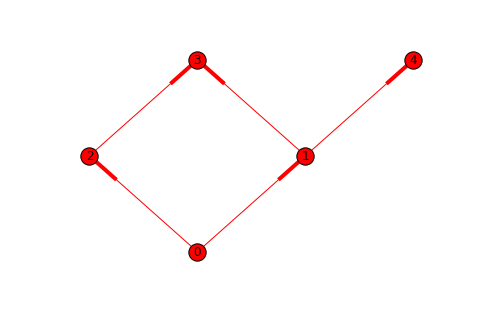

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

import networkx as nx

G = nx.DiGraph()

# add 5 nodes, labeled 0-4:
map(G.add_node, range(5))
# 1,2 depend on 0:
G.add_edge(0,1)
G.add_edge(0,2)
# 3 depends on 1,2
G.add_edge(1,3)
G.add_edge(2,3)
# 4 depends on 1
G.add_edge(1,4)

# now draw the graph:
pos = { 0 : (0,0), 1 : (1,1), 2 : (-1,1),
        3 : (0,2), 4 : (2,2)}
labels = {}
labels[0] = '0'
labels[1] = '1'
labels[2] = '2'
labels[3] = '3'
labels[4] = '4'

nx.draw(G, pos, edge_color='r')
nx.draw_networkx_labels(G,pos,labels,font_size=12)


In [72]:
jobs = {}
for node in G:
    jobs[node] = randomwait

In [73]:
results = {}
lbview = rcc.load_balanced_view()
for node in nx.topological_sort(G):
    deps = [ results[n] for n in G.predecessors(node) ]
    with lbview.temp_flags(after=deps, block=False):
        results[node] = lbview.apply(jobs[node])

In [74]:
lbview.wait(results.values())

True

{'received': datetime.datetime(2016, 7, 18, 10, 53, 3, 894013), 'engine_uuid': 'bb14d49c-7837-46bb-ad63-e34ff2ede858', 'stderr': '', 'execute_input': None, 'data': {}, 'started': datetime.datetime(2016, 7, 18, 10, 52, 57, 888902), 'status': 'ok', 'engine_id': 0, 'submitted': datetime.datetime(2016, 7, 18, 10, 52, 57, 883168), 'after': [], 'stdout': '', 'msg_id': '7846e066-f9cf-4f06-862e-073eb762c979', 'follow': [], 'outputs': [], 'execute_result': None, 'error': None, 'completed': datetime.datetime(2016, 7, 18, 10, 53, 3, 890375)}
{'received': datetime.datetime(2016, 7, 18, 10, 53, 21, 900771), 'engine_uuid': 'ca3dae7d-84c4-4ecf-95f2-e03daa18147b', 'stderr': '', 'execute_input': None, 'data': {}, 'started': datetime.datetime(2016, 7, 18, 10, 53, 3, 895139), 'status': 'ok', 'engine_id': 1, 'submitted': datetime.datetime(2016, 7, 18, 10, 52, 57, 883789), 'after': [], 'stdout': '', 'msg_id': '1894c335-c559-4b6a-8564-b61ab236a5a5', 'follow': [], 'outputs': [], 'execute_result': None, 'erro

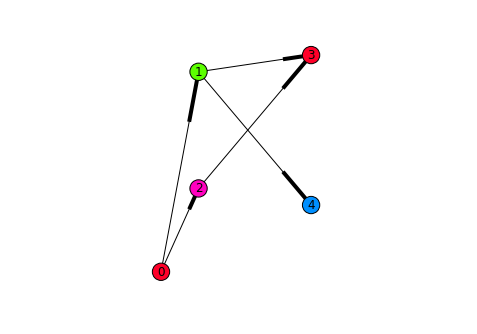

In [78]:
for node in G:
    md = results[node].metadata
    print(md)
    start = date2num(md.started)
    runtime = date2num(md.completed) - start
    pos[node] = (start*100, runtime*10000)
    colors[node] = md.engine_id

nx.draw(G, pos, node_list=list(colors.keys()), node_color=list(colors.values()), cmap=gist_rainbow, with_labels = True)

### Creating a random DAG

In [45]:
def random_dag(nodes, edges):
    """Generate a random Directed Acyclic Graph (DAG) with a given number of nodes and edges."""
    G = nx.DiGraph()
    for i in range(nodes):
        G.add_node(i)
    while edges > 0:
        a = np.random.randint(0,nodes-1)
        b=a
        while b==a:
            b = np.random.randint(0,nodes-1)
        G.add_edge(a,b)
        if nx.is_directed_acyclic_graph(G):
            edges -= 1
        else:
            # we closed a loop!
            G.remove_edge(a,b)
    return G

In [46]:
G = random_dag(32,128)

### Creating a function that is executed by each node

In [47]:
def randomwait():
    import time
    time.sleep(np.random.randint(20))
    return 0

randomwait()

0

In [48]:
jobs = {}
for node in G:
    jobs[node] = randomwait

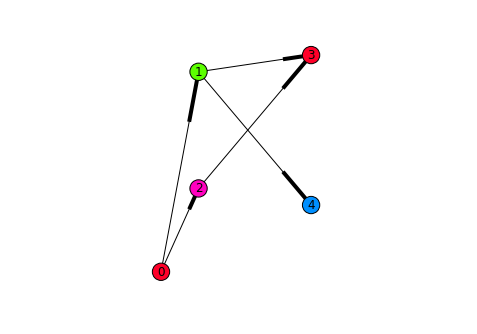

In [76]:
pos = {}; colors = {};
for node in G:
    md = results[node].metadata
    start = date2num(md.started)
    runtime = date2num(md.completed) - start
    pos[node] = (start*100, runtime*10000)
    colors[node] = md.engine_id

nx.draw(G, pos, node_list=list(colors.keys()), node_color=list(colors.values()), cmap=gist_rainbow, with_labels = True)

### Executing the functions with the dependencies given by the DAG

In [49]:
results = {}
lbview = rcc.load_balanced_view()
for node in nx.topological_sort(G):
    deps = [ results[n] for n in G.predecessors(node) ]
    with lbview.temp_flags(after=deps, block=False):
        results[node] = lbview.apply(jobs[node])


In [50]:
lbview.wait(results.values())

True

In [51]:
def validate_tree(G, results):
    """Validate that jobs executed after their dependencies."""
    for node in G:
        started = results[node].metadata.started
        for parent in G.predecessors(node):
            finished = results[parent].metadata.completed
            assert started > finished, "%s should have happened after %s"%(node, parent)

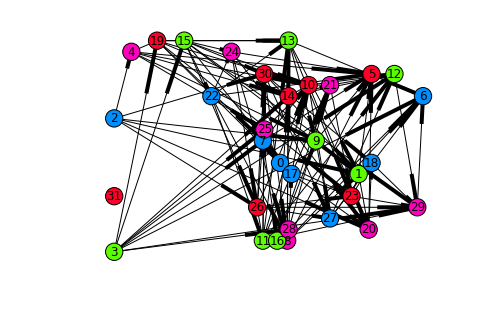

In [70]:
%matplotlib inline

from matplotlib.dates import date2num
from matplotlib.cm import gist_rainbow
pos = {}; colors = {};
for node in G:
    md = results[node].metadata
    start = date2num(md.started)
    runtime = date2num(md.completed) - start
    pos[node] = (start*100, runtime*10000)
    colors[node] = md.engine_id

    
nx.draw(G, pos, node_list=list(colors.keys()), node_color=list(colors.values()), cmap=gist_rainbow, with_labels = True)

